In [1]:
import pandas as pd

In [2]:
# Load df from CSV
df = pd.read_csv("../data/df_bbch.csv", parse_dates=['date'])

print(df.shape)
df.head()

(4542, 29)


,date,station,depth,op,mean_sst,mean_airt,SSM,SST,year,doy,...,VH,VV,angle,lc,BASE_TEMP,cum_GDD_air,cum_GDD_soil,cum_GDD,BBCH,cum_SSM
0,2015-04-25,MB1,0 to 5 cm,0,10.166667,7.8365,0.131444,14.981481,2015,115,...,-20.0,-13.0,40.0,146.0,5,2.8365,5.166667,4.001583,0.0,0.131444
1,2015-04-25,MB11,0 to 5 cm,0,8.616667,8.3805,0.273259,12.581481,2015,115,...,-22.0,-14.0,42.0,158.0,10,2.8365,5.166667,4.001583,0.0,0.404704
2,2015-04-25,MB12,0 to 5 cm,0,5.350000,8.0125,0.311259,14.271247,2015,115,...,-22.0,-12.0,42.0,146.0,5,5.8490,5.516667,5.682833,0.0,0.715963
3,2015-04-25,MB2,0 to 5 cm,0,13.270938,8.3070,0.340557,15.961012,2015,115,...,-18.0,-9.0,40.0,146.0,5,9.1560,13.787605,11.471802,0.0,1.056520
4,2015-04-25,MB3,0 to 5 cm,0,8.716667,9.0030,0.271333,12.774074,2015,115,...,-22.0,-13.0,40.0,158.0,10,9.1560,13.787605,11.471802,0.0,1.327854


In [3]:
from inversion import Inverse

In [4]:
crop_data_final_sorted = {
    133: { # Barley
        'bbch_k_b': [ # Derived from Wheat in Wang et al. 2024 Fig 4 as proxy
            (0, 80, 1), (10, 70, 5), (20, 30, 30), (50, 10, 50), (75, 15, 60), (100, 1, 70)
        ]
    },
    136: { # Oats
        'bbch_k_b': [ # Derived from Wheat in Wang et al. 2024 Fig 4 as proxy
            (0, 80, 1), (10, 70, 5), (20, 30, 30), (50, 10, 50), (75, 15, 60), (100, 1, 70)
        ]
    },
    146: { # Spring Wheat
        'bbch_k_b': [ # Derived from Wang et al. 2024 Fig 4
            (0, 80, 1), (10, 70, 5), (20, 30, 30), (50, 10, 50), (75, 15, 60), (100, 1, 70)
        ]
    },
    147: { # Corn/Maize
        'bbch_k_b': [ # Derived from Wang et al. 2024 Fig 4
            (0, 100, 1), (10, 80, 5), (20, 50, 30), (40, 30, 50), (60, 20, 60), (80, 10, 70), (100, 1, 80)
        ]
    },
    153: { # Canola
        'bbch_k_b': [ # Default - Not in Wang et al. 2024
            (0, 40, 1), (10, 20, 5), (20, 40, 25), (40, 20, 70), (60, 22, 95), (80, 20, 100), (100, 15, 110)
        ]
    },
    157: { # Sunflower
        'bbch_k_b': [ # Default - Not in Wang et al. 2024
            (0, 100, 1), (10, 80, 5), (20, 50, 30), (40, 30, 50), (60, 20, 60), (80, 10, 70), (100, 1, 80)
        ]
    },
    158: { # Soybean
        'bbch_k_b': [ # Default - Not in Wang et al. 2024
            (0, 40, 1), (10, 20, 5), (20, 40, 25), (40, 20, 70), (60, 22, 95), (80, 20, 100), (100, 15, 110)
        ]
    },
    167: { # Dry Beans (Phaseolus)
        'bbch_k_b': [ # Default - Not in Wang et al. 2024
            (0, 40, 1), (10, 20, 5), (20, 40, 25), (40, 20, 70), (60, 22, 95), (80, 20, 100), (100, 15, 110)
        ]
    }
}

In [5]:
crop_bounds = {
    133: {  # Barley
        'cbound': (0, 0.1, 0.5),
        'sbound': (0, 0.025, 0.5), # surface roughness or rms height [m]
        'lbound': (0, 0.075, 0.5), # correlation length [m]
        'wbound': (0, 0.1, 0.5)
    },
    136: {  # Oats
        'cbound': (0, 0.1, 0.5),
        'sbound': (0, 0.025, 0.5),
        'lbound': (0, 0.075, 0.5), # correlation length [m]
        'wbound': (0, 0.1, 0.5)
    },
    146: {  # Spring Wheat
        'cbound': (0, 0.1, 0.5),
        'sbound': (0, 0.025, 0.5),
        'lbound': (0, 0.075, 0.5), # correlation length [m]
        'wbound': (0, 0.1, 0.5)
    },
    147: {  # Corn
        'cbound': (0, 0.1, 0.5),
        'sbound': (0, 0.025, 0.5),
        'lbound': (0, 0.075, 0.5), # correlation length [m]
        'wbound': (0, 0.1, 0.5)
    },
    153: {  # Canola and Rapeseed
        'cbound': (0, 0.1, 0.5),
        'sbound': (0, 0.025, 0.5),
        'lbound': (0, 0.075, 0.5), # correlation length [m]
        'wbound': (0, 0.1, 0.5)
    },
    157: {  # Sunflower
        'cbound': (0, 0.1, 0.5),
        'sbound': (0, 0.025, 0.5),
        'lbound': (0, 0.075, 0.5), # correlation length [m]
        'wbound': (0, 0.1, 0.5)
    },
    158: {  # Soybeans
        'cbound': (0, 0.1, 0.5),
        'sbound': (0, 0.025, 0.5),
        'lbound': (0, 0.075, 0.5), # correlation length [m]
        'wbound': (0, 0.1, 0.5)
    },
    167: {  # Beans
        'cbound': (0, 0.1, 0.5),
        'sbound': (0, 0.025, 0.5),
        'lbound': (0, 0.075, 0.5), # correlation length [m]
        'wbound': (0, 0.1, 0.5)
    }
}

In [6]:

# Set the bacscattering models
RT_models = {
    'RT_s': 'PRISM1', # options: 'AIEM', 'PRISM1'
    'RT_c': 'Diff' # options: 'Diffuse', 'Specular'
}

inv = Inverse(fGHz=5.405, models=RT_models, acftype='exp', crop_bbch_k_b_coff=crop_data_final_sorted)

In [7]:
inv_df = inv.run(df, crop_bounds)

0
3
4
5
6
7
8
9
10
1
2
11
15
16
17
18
19
20
21
22
13
14
12
23
27
28
29
30
31
32
33
34
25
26
24
35
39
40
41
42
43
44
45
46
36
37
38
47
51
52
53
54
55
56
57
58
48
49
50
62
60
61
59
63
67
68
69
70
71
72
73
74
64
65
66
75
79
80
81
82
83
84
85
86
77
78
76
87
91
92
93
94
95
96
97
98
88
89
90
99
103
104
105
106
107
108
109
110
100
101
102
111
115
116
117
118
119
120
121
122
112
113
114
123
127
128
129
130
131
132
133
134
125
126
124
135
139
140
141
142
143
144
145
146
136
137
138
147
151
152
153
154
155
156
157
158
149
150
148
159
163
164
165
166
167
168
169
170
160
161
162
171
175
176
177
178
179
180
181
182
173
174
172
185
186
187
188
189
190
191
183
184
196
192
197
198
199
200
201
202
203
204
194
195
193
205
206
207
211
212
213
214
215
216
209


/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n

210
208
221
217
222
223
224
225
226
227
228
219


/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n

220
218
229
230
234
235
236
237
238
239
240
241
231
232
233
246
242
247
248
249
250
251


/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n

252
253
254
244
245
243
255
256


/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n

260
261
262
263
264
265
266
267
257
258


/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n

259
272
268
273
274
275
276
277
278
279
280
270
271
269
293
294
298
299
300
301
302
303


/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n

304
305
295
296
297
318
319
323
324
325
326
327
328
329
330
320
321
322
335
331
336
337
338
339
340
341
342
343
333
334
332
344
345
349
350
351
352
353
354
355
356
346
347
348
361
357
362
363
364
365
366
367
368
369
359
360
358
370
371
375
376
377
378
379
380
381
382
372
373
374
387
383
388
389
390
391
392
393
394
395
385
386


/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n

384
396
397
401
402
403
404
405
406
407
408
398


/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n

399
400
413
409
414
415
416
417
418
419
420
421
411
412
410
422
423
427


/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n

428
429
430
431
432
433
434
424
425
426
439
435
440
441
442
443
444
445
446


/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n

437
438
436
451
447
452
453
454
455
456
457
458
459
449
450
448
464
460
465
466
467
468
469
470
471
472
462
463
461
473
474
478
479
480
481
482
483
484


/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n

485
475
476
477
490
486
491
492
493
494
495
496
497
488
489
487
498
499
503
504
505
506
507
508
509
510
500
501
502
515
511
516
517
518
519
520
521
522
523
513
514
512
524
525
529
530
531
532
533
534
535
536
526
527
528
541
537
542
543
544
545
546
547
548
549
539
540
538
550
554
555
556
557
558
559
560
561
551
552
553
566
562
567
568
569
570
571
572
573
574
564
565
563
575
579
580
581
582
583
584
585
586
576
577
578
587
591
592
593
594
595
596
597
598
589
590
588
599
600
604
605
606
607
608
609
610
611
601
602
603
616
612
617
618
619
620
621
622
623
624
614
615
613
629
625
630
631
632
633
634
635
636
637
627
628
626
641
642
643
644
645
646
647
648
638
639
640
649
653
654
655
656
657
658
659
651
652
650
664
660
665
666
667
668
669
670
671
672
662
663
661
673
674
678
679
680
681
682
683
684
685
675
676
677
690
686
691
692
693
694
695
696
697
698
688
689
687
699
704
700
705
706
707
708
709
710
711
712
702
703
701
713
714
718
719
720
721
722
723
724
725
715
716
717
730
726
731
732
733
734


/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n

818
819
831
828
832
833
834
835
836
837
838


/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n

839
829
830
840
841
845
846
847
848
849
850
851
852
842
843
844
857
853
858
859
860
861
862
863
864
855
856
854
865
869
870
871
872
873
874
875
876
866
867
868
881
877
882
883
884
885
886
887
888
889
879
880
878
890
894
895
896
897
898
899
900
901
891
892
893
906
902
907
908
909
910
911
912
913
914
904
905
903
915
916
920
921
922
923
924
925
926
917
918
919
927
928
932
933
934
935
936
937
938
939
929
930
931
944
940
945
946
947
948
949
950
951
952
942
943
941
953
954
958
959
960
961
962
963
964
965
955
956
957
966
971
967
972
973
974
975
976
977
978
979
969
970
968
980
984
985
986
987
988
989


/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n

990
991
981
982
983
996
992
997
998


/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n

999
1000
1001
1002
1003
1004
994
995
993
1005
1006
1010
1011
1012
1013
1014
1015
1016
1017
1007
1008
1009
1018
1019
1022
1023


/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n

1024
1025
1026
1027
1028
1029
1020
1021
1034
1030
1035
1036
1037
1038
1039
1040
1041
1042
1032
1033
1031
1043
1044
1048
1049
1050
1051
1052
1053


/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n

1054
1055
1045
1046
1047
1056


/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n

1060
1061
1062
1063
1064
1065
1066
1067
1057
1058
1059
1071
1068
1072
1073
1074
1075
1076
1077
1078
1079
1070
1069
1080
1084
1085
1086
1087
1088
1089
1090
1091
1081
1082
1083
1092
1096
1097
1098
1099
1100
1101
1102
1094
1095
1093
1103
1107
1108
1109
1110
1111
1112
1113
1114
1104
1105
1106
1119
1115
1120
1121
1122
1123
1124
1125
1126
1127
1117
1118
1116
1128
1132
1133
1134


/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n

1135
1136
1137
1138
1139
1129
1130
1131
1144
1140
1145
1146
1147
1148
1149
1150
1151
1152
1142
1143
1141
1153
1157
1158
1159
1160
1161
1162
1163
1164
1154
1155
1156
1165
1169
1170
1171
1172
1173
1174
1175
1176
1167
1168
1166
1177
1181
1182
1183
1184
1185
1186
1187
1188
1178
1179
1180
1193
1189
1194
1195
1196
1197
1198
1199
1200
1191
1192
1190
1204
1205
1206


/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n

1207
1208
1209
1210
1202
1203
1201
1214
1215
1216
1217
1218
1219
1220
1221
1211
1212
1213
1226
1222
1227
1228
1229
1230
1231
1232
1224
1225
1223
1233
1237
1238
1239
1240
1241
1242
1243
1234
1235
1236
1244
1248
1249
1250
1251
1252
1253
1246
1247
1245
1257
1258
1259
1260
1261
1262
1263
1254
1255
1256
1264
1268
1269
1270
1271
1272
1273
1274
1265
1266
1267
1275
1279
1280
1281
1282
1283
1284
1285
1286
1276
1277
1278
1287
1291
1292
1293
1294
1295
1296
1297
1298
1289
1290
1288
1299
1303
1304
1305
1306
1307
1308
1309
1300
1301
1302
1310
1314
1315
1316
1317
1318
1319
1320
1312
1313
1311
1321
1325
1326
1327
1328
1329
1330
1331
1332
1322
1323
1324
1337
1333
1338
1339
1340
1341
1335
1336
1334
1344
1345
1346
1342
1343
1347
1348
1351
1352
1353
1354
1355
1356
1349
1350
1357
1361
1362
1363
1364
1365
1366
1367
1368
1358
1359
1360
1369
1373
1374
1375
1376
1377
1378
1379
1380
1371
1372
1370
1383
1384
1385
1386
1387
1388
1389
1390
1381
1382
1394
1395
1396
1397
1392
1393
1391
1398
1401
1402
1403
1404
1405


/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n

1541
1542
1543
1533
1534
1532
1544
1545
1549
1550
1551
1552
1553
1554
1555
1556
1546
1547
1548
1561
1557
1562
1563
1564
1565
1566
1567
1568
1569
1559
1560
1558
1570
1571
1574
1575
1576
1577
1578
1579
1580
1581
1572
1573


/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n

1585
1582
1586
1587
1588
1589
1590
1591
1592
1593


/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n

1584
1583
1594
1595
1598
1599
1600
1601
1602
1603
1604
1596


/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n

1597
1607
1605
1608
1609
1610
1611
1612
1613
1606
1614
1615


/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n

1617
1618
1619
1620
1621
1622
1616
1626
1623
1627
1628
1629
1630
1631
1632
1625
1624
1633
1634
1638
1639
1640
1641
1642
1635
1636
1637
1646
1647
1648
1649
1650
1651
1652
1653
1644
1645
1643
1654
1655
1659
1660
1661
1662
1663
1664
1665
1666
1656
1657
1658
1669
1670
1671
1672
1673
1674
1675
1668
1667
1676
1677
1681
1682
1683
1684
1685
1686
1687
1688
1678


/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n

1679
1680
1691
1692
1693
1694
1695
1696
1697
1690


/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n

1689
1698
1699
1703
1704
1705
1706
1707
1700
1701
1702
1710
1711
1712
1713
1714
1715
1716
1708
1709
1717
1718
1722
1723
1724
1725
1726
1727
1728
1729
1719
1720
1721
1734
1730
1735
1736
1737
1738
1739
1740
1741
1732
1733
1731


/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n

1742
1743
1744
1748
1749
1750
1751
1745
1746
1747
1753
1752
1754
1755
1756
1757
1758
1759
1760
1761
1762
1763
1764
1765
1766
1767
1770
1771
1772
1773
1774
1768
1769
1775
1776
1777
1778
1779
1780
1781
1782
1783
1784
1785
1786
1787
1788
1789
1790
1791
1792
1793
1794
1795
1796
1797
1798
1799
1800
1801
1802
1803
1804
1805
1806
1808
1809
1810
1811
1812
1807
1813
1814
1815
1817
1818
1819
1820
1821
1816
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1839
1840
1841
1842
1843
1844
1845
1846
1836
1837
1838
1847
1848
1852
1853
1854
1855
1856
1857
1858
1859
1849
1850
1851
1864
1860
1865
1866
1867
1868
1869
1870
1862
1863
1861
1871
1875
1876
1877
1878
1879
1880
1872
1873
1874
1884
1881
1885
1886
1887
1882
1883
1888
1889
1890
1891
1894
1895
1896
1893
1892
1898
1899
1900
1901
1897
1906
1902
1907
1908
1909
1910
1911
1912
1913
1914
1904
1905
1903
1915
1917
1918
1919
1920
1921
1922
1923
1924
1916
1925
1927
1928
1929
1930
1926
1931
1934
1935
1936
1932
1933
1941
1937
1942
1943
1944


/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n

2062
2067
2068
2069
2070
2071
2072
2073
2064
2065
2063
2074
2075
2079
2080
2081
2082
2083
2084
2085
2086
2076
2077
2078
2090
2091
2092
2093
2094
2095
2096
2097
2088
2089
2087
2098
2099
2103
2104
2105
2106
2107
2108
2109
2110
2100
2101
2102
2115
2111
2116
2117
2118
2119
2120
2121
2122
2123
2113
2114
2112
2124
2127
2128
2129
2130
2131
2132
2133
2125
2126
2138
2134
2139
2140
2141
2142
2143
2144
2145
2146
2136
2137
2135
2147
2148
2151
2152
2153
2154
2155
2156
2157
2158
2149
2150
2163
2159
2164
2165
2166
2167
2168
2169
2170
2171
2161
2162
2160
2172
2173
2177
2178
2179
2180
2181
2182
2183
2184
2174
2175
2176
2189
2185
2190
2191
2192
2193
2194
2195
2196
2197
2187
2188
2186
2198
2201
2202
2203
2204
2205
2199
2200
2210
2206
2211
2212
2213
2214
2215
2216


/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n

2217
2218
2208
2209
2207
2219
2220
2223
2224
2225
2226
2227
2228
2229
2230
2221
2222
2233
2234
2235
2236
2237
2238
2239
2232
2231
2242
2243
2244
2240
2241
2245
2248
2249
2250
2251
2252
2253
2246
2247
2258
2254
2259
2260
2261
2262
2263


/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n

2264
2265
2266
2256
2257
2255
2267
2269


/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n

2270
2271
2272
2273
2268
2276
2277
2278
2279
2280
2275
2274
2282
2281
2284
2283
2285
2286
2289
2290
2288
2287
2292
2293
2291
2294
2297
2298
2299
2300
2301
2302
2303
2295
2296
2306
2304
2307
2308
2309
2310
2311


/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n

2312
2313
2305
2314
2318
2319
2320
2321
2322
2323
2315
2316
2317
2326
2324
2327
2328
2329
2330


/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n

2331
2332
2333
2325
2334
2337
2338
2339
2340
2341
2342
2343
2344
2335
2336
2347
2345
2348
2349
2350
2351
2352


/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n

2353
2354
2346
2355
2359
2360
2361
2362
2363
2364
2365
2366
2356
2357
2358
2369
2367
2370
2371
2372
2373
2374


/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n

2375
2376
2377
2368
2378
2382
2383
2384
2385
2386
2387
2388
2389
2379
2380
2381
2390
2391
2395
2396
2397
2398
2399
2400
2401
2402
2392
2393
2394
2405
2403
2406
2407
2408
2409
2410
2411
2412
2413
2404
2414
2415
2419
2420
2421
2422
2423
2424
2425
2426
2416
2417
2418
2431
2427
2432
2433
2434
2435
2436
2437
2438
2439
2429
2430
2428
2440
2444
2441
2445
2446
2447
2448
2449
2450
2451
2452
2442
2443
2457
2453
2458
2459
2460
2461
2462
2463
2464


/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n

2465
2455
2456
2454
2466
2470
2471
2472
2473
2474
2475
2476
2477
2467
2468
2469
2478
2482
2483
2484
2485
2486
2487
2488
2489
2479
2480
2481
2494
2490
2495
2496
2497
2498
2499
2500
2501
2492
2493
2491
2502
2503
2507
2508
2509
2510
2511
2512
2513
2514
2504
2505
2506
2519
2515
2520
2521
2522
2523
2524
2525
2526
2527
2517
2518
2516
2528
2529
2533
2534
2535
2536
2537
2538
2539
2540
2530
2531
2532
2545
2541
2546
2547
2548
2549
2550
2551
2552
2553
2543
2544
2542
2554
2558
2559
2560
2561
2562
2563
2564
2565
2555
2556
2557
2570
2566
2571
2572
2573
2574
2575
2576
2577
2578
2568
2569
2567
2579
2583
2584
2585
2586
2587
2588
2589
2590
2580
2581
2582
2595
2591
2596
2597
2598
2599
2600
2601
2602
2603
2593
2594
2592
2604
2605
2609
2610
2611
2612
2613
2614
2615
2616
2606
2607
2608
2621
2617
2622
2623
2624
2625
2626
2627
2628
2629
2619
2620
2618
2630
2631
2635
2636
2637
2638
2639
2640
2641
2642
2632
2633
2634
2647
2643
2648
2649
2650
2651
2652
2653
2654
2655
2645
2646
2644
2656
2660
2661
2662
2663
2664


/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n

2747
2748
2749
2750
2751
2752
2753
2754
2744
2745
2746
2759
2755


/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n

2760
2761
2762
2763
2764
2765
2766
2757
2758
2756
2767
2768


/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n

2772
2773
2774
2775
2776
2777
2778
2779
2769
2770
2771
2784
2780
2785
2786
2787
2788
2789
2790
2791
2782
2783
2781
2792
2793
2797
2798
2799
2800
2801
2802
2803
2804
2794
2795
2796
2809
2805
2810
2811
2812
2813
2814
2815
2816
2817
2807
2808
2806
2818
2822
2823
2824
2825
2826
2827
2828
2829
2819
2820
2821
2833
2830
2834
2835
2836
2837
2838
2839
2840
2841
2832
2831
2842
2846
2847
2848
2849
2850
2851
2852
2853
2843
2844
2845
2856
2857
2858
2859
2860
2861
2855
2854
2862
2866
2867
2868
2869
2870
2871
2872
2873
2863
2864
2865
2876
2877
2878
2879
2880
2881
2882
2883
2884
2875
2874
2885
2889
2890
2891
2892
2893
2894
2895
2896
2886
2887
2888
2900
2897
2901
2902
2903
2904
2905
2906
2898
2899
2907
2911
2912
2913
2914
2915
2916
2917
2918
2908
2909
2910
2920
2919
2921
2922
2923
2924
2925
2926
2927
2928
2932
2933
2934
2935
2936
2937
2938
2939
2929
2930
2931
2942
2940
2943
2944
2945
2946
2947
2941
2948
2952
2953
2954
2955
2956
2957
2958
2959
2949
2950
2951
2962
2963
2964
2965
2966
2967
2968
2969
2961


/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n

2983
2993
2996
2997
2998
2999
3000
3001
3002
3003
2994
2995
3008
3004
3009
3010
3011
3012
3013
3014
3015
3006
3007
3005
3016
3020
3021
3022
3023
3024
3025
3026


/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n

3027
3017
3018
3019
3032
3028
3033
3034
3035
3036
3037
3038
3039
3040
3030
3031
3029
3041
3042
3043
3044
3045
3046
3047
3048
3049
3053
3050
3054
3055
3056
3057
3058
3059
3060
3051
3052
3061
3065
3066
3067
3068
3069
3070
3071
3072
3062
3063
3064
3074
3073
3075
3076
3077
3078
3079
3080
3081
3082
3083
3087
3088
3089
3090
3091
3092
3093
3094
3084
3085
3086
3097
3095
3098
3099
3100
3101
3102
3103
3104
3096
3105
3109
3110
3111
3112
3113
3114
3115
3106
3107
3108
3116
3117
3118
3119
3120
3121
3122
3123
3124
3128
3129
3130
3131
3132
3133
3134
3135
3125
3126
3127
3136
3137
3138
3139
3140
3141
3142
3143
3144
3145
3149
3150
3151
3152
3153
3154
3155
3156
3146
3147
3148
3158
3157
3159
3160
3161
3162
3163


/home/debian/usask_work/inversion/src/inversion/inverse.py:45: RuntimeWarning: divide by zero encountered in log10
  return 10*np.log10(power)


3164
3165
3166
3167
3169
3168
3170
3171
3172
3173
3174
3175
3176
3177
3181
3182
3183
3184
3185
3186
3187
3188
3178
3179
3180
3193
3189
3194
3195
3196
3197
3198
3199
3200
3201
3191
3192
3190
3202
3203
3207
3208
3209
3210
3211
3212
3213
3214
3204
3205
3206
3219
3215
3220
3221
3222
3223
3224
3225
3226
3227
3217
3218
3216
3228
3229
3233
3234
3235
3236
3237
3238
3239
3240
3230
3231
3232
3241
3242
3246
3247
3248
3249
3250
3251
3252
3253
3243
3244
3245
3258
3254
3259
3260
3261
3262
3263
3264
3265
3266
3256
3257
3255
3267
3268
3269
3273
3274
3275
3276
3277
3278
3279
3280
3270
3271
3272
3285
3281
3286
3287
3288
3289
3290
3291
3292
3293
3283
3284
3282
3294
3299
3295
3300
3301
3302
3303
3304
3305
3306
3307
3297
3298
3296
3308
3309
3313
3314
3315
3316
3317
3318
3319
3320
3310
3311
3312
3325
3321
3326
3327
3328
3329
3330
3331
3332
3323
3324
3322
3333
3334
3338
3339
3340
3341
3342
3343
3344
3345
3335
3336
3337
3350
3346
3351
3352
3353
3354
3355
3356
3357
3358
3348
3349
3347
3359
3360
3364
3365
3366


/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n

308
309
310
311
312
313
314
306
315
316
317
3542
3543
3544
3545
3546
3547
3548
3541
3549
3550
3551
3552
3553
3554
3555


/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n

3556
3557
3558
3559
3561
3562
3563
3564
3565
3566
3560
3567
3568
3569


/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n

3570
3571
3572
3573
3574
3575
3576
3577
3579
3580
3581
3582
3583


/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n

3584
3585
3578
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3598
3599
3600
3601
3602
3603
3604
3605
3597
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3618
3619
3620
3621
3622
3623
3617
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3636
3637
3638
3639
3640
3641
3642
3643
3635
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3656
3657
3658
3659
3660
3661
3655
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3673
3674
3675
3676
3677
3678
3679
3680
3672
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691


/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n

3693
3694
3695
3696
3697
3698
3699
3692
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3712
3713
3714
3715
3716
3717
3718
3719
3711
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3740
3741
3742
3743
3744
3745
3746
3747
3739
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3760
3761
3762
3763
3764
3765
3766
3767
3759
3768
3769
3770
3771
3772
3773
3774
3775
3776
3777
3778
3780
3781
3782
3783
3784
3785
3786
3787
3779
3788
3789
3790
3791
3792
3793
3794
3795
3796
3797
3798
3800
3801
3802
3803
3804
3805
3806
3807
3799
3808
3809
3810
3811
3812
3813
3814
3815
3816
3817
3818
3820
3821
3822
3823
3824
3825
3826
3827
3819
3828
3829
3830
3831
3832
3833
3834
3835
3836
3837
3838
3840
3841
3842
3843
3844
3845
3846
3847
3839
3848
3849
3850
3851
3852
3853
3854
3855
3856
3857
3858
3860
3861
3862
3863
3864
3865
3866
3867
3859
3868
3869
3870
3871
3872
3873
3874
3875
3876
3877
3878
3880
3881
3882
3883
3884
3885
3886
3887
3879
3888
3889
3890
3891


/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n

3990
3991
3992
3993
3994
3995
3996
3998
3999
4000
4001
4002


/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n

4003
4004
3997
4005
4006
4007
4008
4009
4010
4011
4012
4013
4014
4016
4017
4018
4019
4020
4021
4022
4015
4023
4024
4025


/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n

4026
4027
4028
4029
4030
4031
4032
4033
4035
4036
4037
4038
4039
4040


/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n

4034
4041
4042
4043
4044
4045
4046
4047
4048
4049
4050
4052
4053
4054
4055
4056
4057
4058
4051
4059
4060
4061
4062
4063
4064
4065
4066
4067
4068
4069
4071
4072
4073
4074
4075
4076
4070
4077
4078
4079
4080
4081
4082
4083
4084
4085
4086
4087
4089
4090
4091
4092
4093
4094
4095
4096
4088
4097
4098


/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n

4099
4100
4101
4102
4103
4104
4105
4106
4107
4109
4110
4111
4112
4113
4114
4115
4108


/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n

4116
4117
4118
4119
4120
4121
4122
4123
4124
4125
4126
4128
4129
4130
4131
4132
4127
4133
4134
4135
4136
4137
4138
4139
4140
4141
4142
4143
4145
4146
4147
4148
4149
4150
4144
4151
4152
4153
4154
4155
4156
4157
4158
4159
4160
4161
4162
4163
4164
4165
4166
4167
4168
4169
4171
4172
4173
4174
4175
4176
4177
4170
4178
4179
4180
4181
4182
4183
4184
4185
4186
4187
4188
4190
4191
4192
4193
4194
4195
4196
4197
4189
4198
4199
4200
4201
4202
4203
4204
4205
4206
4207
4209
4210
4211
4212
4213
4214
4215
4216
4208
4217
4218
4219
4220
4221
4222
4223
4224
4225
4226
4227
4229
4230
4231
4232
4233
4234
4235
4228
4236
4237
4238
4239
4240
4241
4242
4243
4244
4245
4246
4248
4249
4250
4251
4252
4254
4255
4247
4253
4256
4257
4258
4259
4260
4261
4262
4263
4264
4265
4266
4268
4269
4270
4271
4272
4273
4274
4275
4267
4276
4277
4278
4279
4280
4281
4282
4283
4284
4285
4286
4288
4289
4290
4291
4292
4293
4294
4295
4287
4296
4297
4298
4299
4300
4301
4302
4303
4304
4305
4306
4308
4309
4310
4311
4312
4314
4315
4307
4313


/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n

4467
4468
4469
4470
4471
4472
4473
4475
4476
4477
4478
4479
4480
4481
4474
4482
4483
4484
4485
4486
4487
4488
4489
4490
4491
4493
4494
4495
4496
4497
4498
4499
4500
4492
4501
4502
4503
4504
4505
4506
4507
4508
4509
4510
4511
4513
4514
4515
4516
4517
4518
4519
4520
4512
4521
4522
4523
4524
4525
4526
4527
4528
4529


/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/debian/usask_work/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n

4530
4531
4532
4533
4534
4536
4535
4537
4538
4539
4540
4541


/home/debian/usask_work/inversion/src/inversion/inverse.py:30: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(['op', 'year', 'doy', 'angle'], group_keys=False).apply(lambda x: self.inversion(x, crop_bounds))


In [8]:
print(inv_df.shape)
inv_df.head()

(4424, 37)


,date,station,depth,op,mean_sst,mean_airt,SSM,SST,year,doy,...,BBCH,cum_SSM,d,c,w,vvv,vvs,s,l,rvi
0,2015-04-25,MB1,0 to 5 cm,0,10.166667,7.8365,0.131444,14.981481,2015,115,...,0.0,0.131444,0.542216,0.223872,0.038168,-15.143286,-17.094702,0.002778,0.075,0.665350
1,2015-04-25,MB11,0 to 5 cm,0,8.616667,8.3805,0.273259,12.581481,2015,115,...,0.0,0.404704,0.229865,0.388830,0.000165,-17.824103,-16.325193,0.002802,0.075,0.547228
2,2015-04-25,MB12,0 to 5 cm,0,5.350000,8.0125,0.311259,14.271247,2015,115,...,0.0,0.715963,0.300340,0.295478,0.000311,-15.626653,-14.470647,0.003304,0.075,0.363636
3,2015-04-25,MB2,0 to 5 cm,0,13.270938,8.3070,0.340557,15.961012,2015,115,...,0.0,1.056520,0.367737,0.231935,0.037651,-11.998367,-12.022266,0.004321,0.075,0.447263
4,2015-04-25,MB3,0 to 5 cm,0,8.716667,9.0030,0.271333,12.774074,2015,115,...,0.0,1.327854,0.188837,0.152568,0.073076,-15.188573,-17.024662,0.002222,0.075,0.447263


In [ ]:
# inv_df.to_csv("../data/inv_df.csv", index=False)

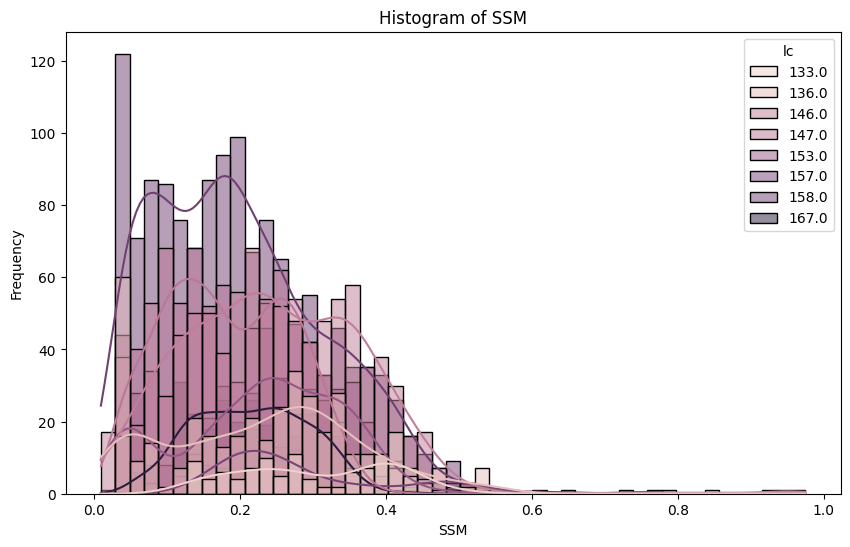

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'gp_merged' DataFrame is already created as in the provided code.

plt.figure(figsize=(10, 6))
sns.histplot(inv_df, x='SSM', kde=True, hue='lc')
plt.title('Histogram of SSM')
plt.xlabel('SSM')
plt.ylabel('Frequency')
plt.show()

/tmp/ipykernel_7185/369816459.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i].legend(loc='upper left', bbox_to_anchor=(1, 1))


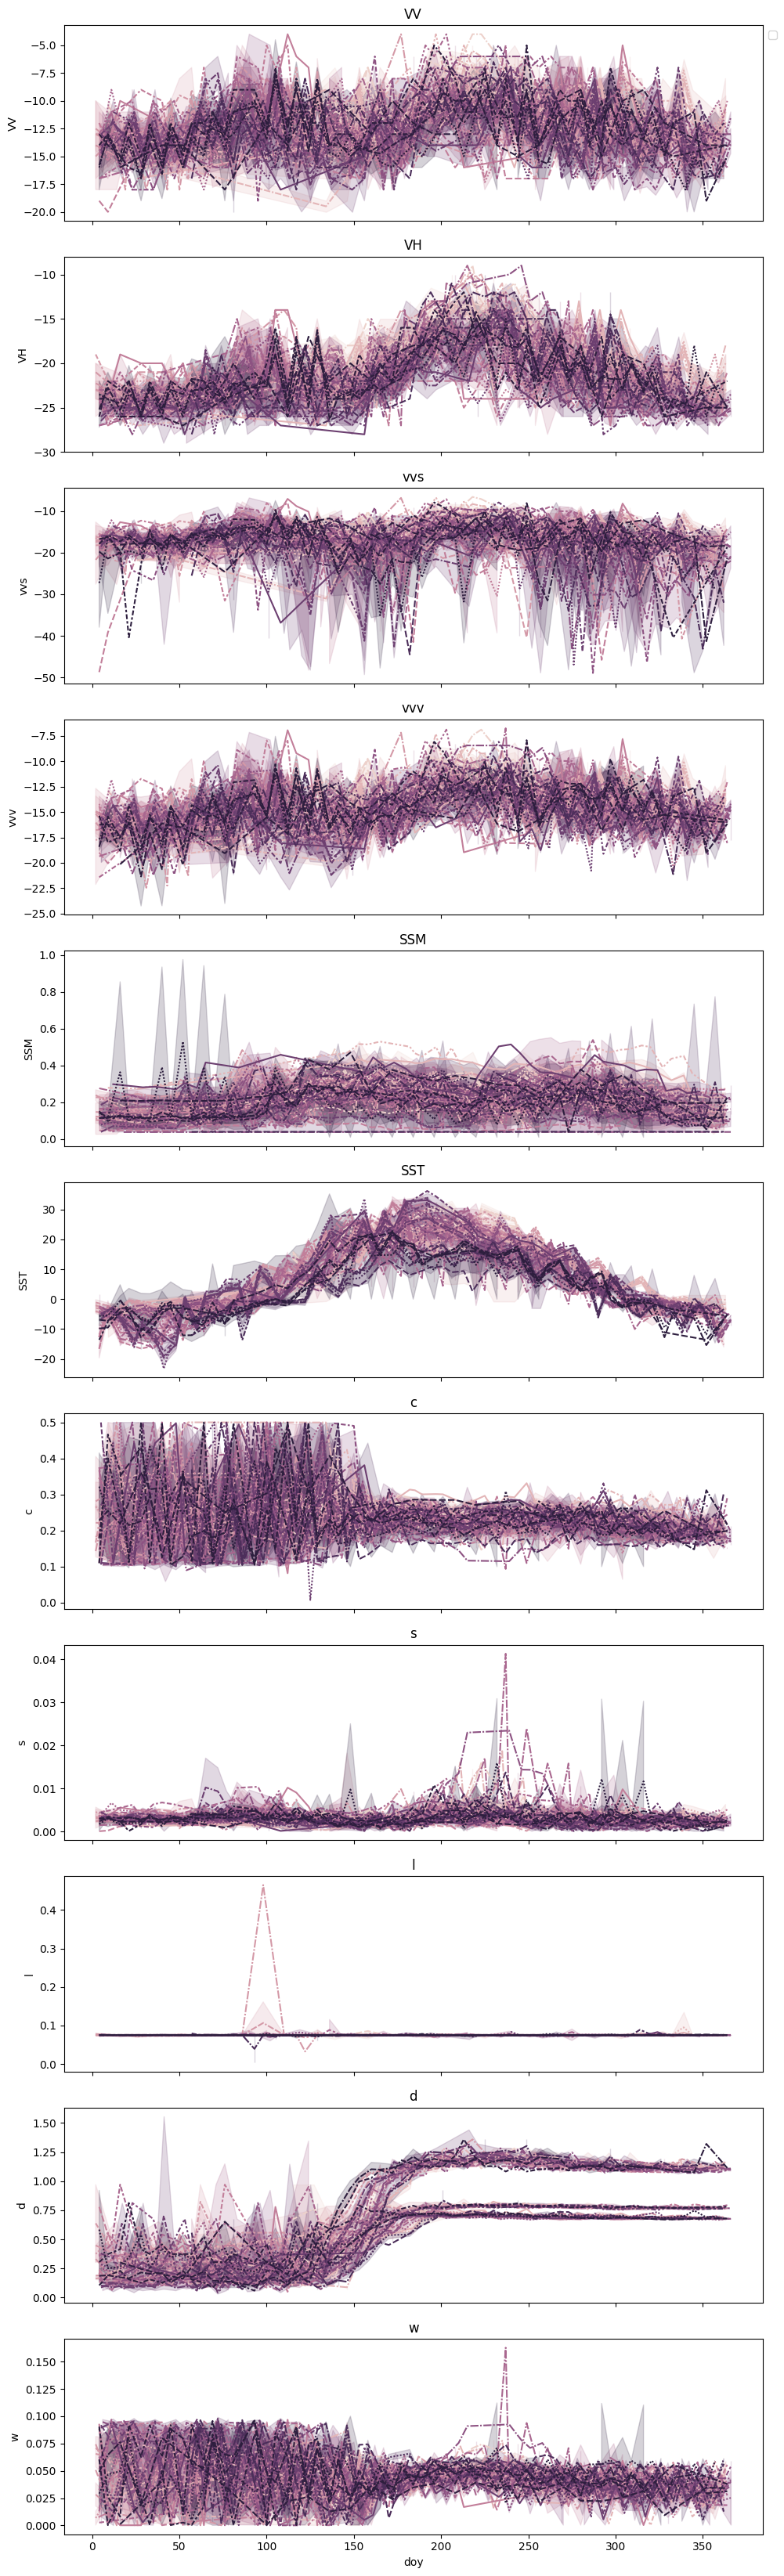

In [10]:
# Assuming 'gp_merged' DataFrame is already created as in the provided code.

parameters = ['VV', 'VH', 'vvs', 'vvv', 'SSM', 'SST', 'c', 's', 'l', 'd', 'w']
num_parameters = len(parameters)

fig, axes = plt.subplots(num_parameters, 1, figsize=(10, 3 * num_parameters), sharex=True)

for i, param in enumerate(parameters):
    sns.lineplot(ax=axes[i], x='doy', y=param, data=inv_df, hue='year', style='lc', legend=False)
    axes[i].set_title(param)
    # Add legend only to the first subplot
    if i == 0:
        axes[i].legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()